# Network Reduction

pynucastro has an implementation of the directed relation graph with error propagation
(DRGEP) reduction method described in {cite:t}`pepiot-desjardins:2008` and {cite:t}`niemeyer:2011`.

Let's consider an example of H/He burning in X-ray bursts, where we expect hot-CNO and rp-process to dominate.

In [1]:
import pynucastro as pyna

First we will create a large network with all the rates connecting nuclei up to a maximum Z and A.  We'll pick ${}^{60}\mathrm{Zn}$ as this endpoint.

We will first create a library will all possible rates and then filter it to remove the rates connecting nuclei heavier than we wish.

Let's combine the entire ReacLib library with the tabulated rates, and eliminate any duplicates (by keeping the tabulated weak rate over the ReacLib version).

In [2]:
all_lib = pyna.ReacLibLibrary() + pyna.TabularLibrary(ordering=["ffn", "langanke", "oda"])

In [3]:
dupes = all_lib.find_duplicate_links()
rates_to_remove = []
for d in dupes:
    for r in d:
        if isinstance(r, pyna.rates.ReacLibRate):
            rates_to_remove.append(r)

for r in rates_to_remove:
    all_lib.remove_rate(r)

Now we can create our {py:obj}`RateFilter <pynucastro.rates.library.RateFilter>`.

In [4]:
Z_max = 30
A_max = 60

In [5]:
filter = pyna.RateFilter(filter_function=lambda r:
                            max(n.A for n in r.reactants + r.products) <= A_max and
                            max(n.Z for n in r.reactants + r.products) <= Z_max)

and filter our library

In [6]:
lib = all_lib.filter(filter)

Now we can create a network.  We'll do a basic {py:obj}`RateCollection <pynucastro.networks.rate_collection.RateCollection>`

In [7]:
net = pyna.RateCollection(libraries=[lib])

We can look at the network.

In [8]:
net.summary()

Network summary
---------------
  explicitly carried nuclei: 660
  approximated-out nuclei: 0
  inert nuclei (included in carried): 0

  total number of rates: 7968

  rates explicitly connecting nuclei: 7968
  hidden rates: 0

  reaclib rates: 7562
  tabular rates: 406
  approximate rates: 0
  derived rates: 0
  modified rates: 0
  custom rates: 0


We see that we have > 600 nuclei!  This is quite large.  Our objective now is to remove the nuclei that might not be important.

First we need to create a list of thermodynamic states that we want to consider.  We can do this manually, or we can create a generator that works within some bounds using the {py:meth}`dataset <pynucastro.reduction.generate_data.dataset>` method.  We'll do it manually here.

 For this example, we'll just use the same composition for all states, but we can create unique compositions (and even sample a real simulation using yt and the tools in {py:mod}`yt_utils <pynucastro.yt_utils>`).

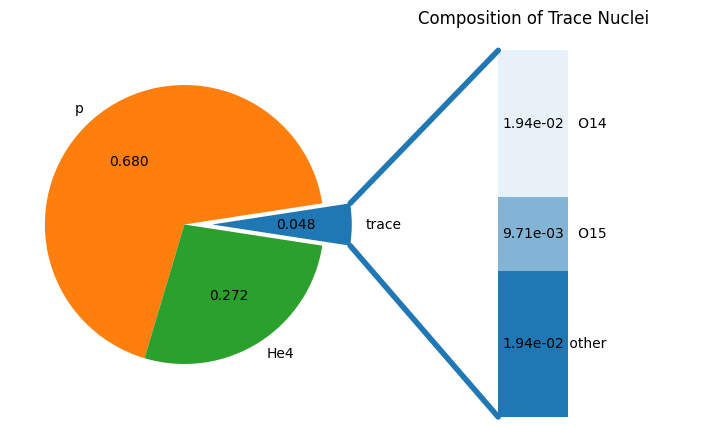

In [9]:
comp = pyna.Composition(net.unique_nuclei)
comp.set_solar_like()
comp.X[pyna.Nucleus("o14")] = 0.02
comp.X[pyna.Nucleus("o15")] = 0.01
comp.normalize()
fig = comp.plot()

We want the data as tuples in the form (composition, density, temperature).  We'll make a few difference density + temperature choices.

In [10]:
data = [(comp, 1.e4, 1.e8),
        (comp, 1.e5, 2.e8),
        (comp, 1.e5, 1.e9),
        (comp, 5.e5, 2.e9)]

Next we create a list of target nuclei that we care about.  This can be a list of names or `Nucleus` objects.  If you definitely want a nucleus in your network, then you should include it here.  We'll add (hot-)CNO, some rp-breakout, and a basic alpha chain.

In [11]:
targets = ["p", "he4",
           "n13", "n14", "n15",
           "c12", "c13",
           "o14", "o15", "o16", "o17", "o18",
           "f18", "f19",
           "ne18", "ne19", "ne20",
           "na22", "na23",
           "mg24", "si28", "s32", "ar36", "ca40", "ti44", "cr48", "fe52", "ni56"]

Finally we need a tolerance (or list of tolerances) for each nucleus.  The higher the tolerance, the fewer nuclei will remain in the network.  We'll pick a single value for all nuclei here.

In [12]:
tol = 0.9

We can now run the DRGEP algorithm via {py:meth}`drgep <pynucastro.reduction.drgep_module.drgep>`.
It will return a new network (of the same class) by default.

In [13]:
reduced_net = pyna.drgep(net=net, conds=data, targets=targets, tols=tol)

In [14]:
reduced_net.summary()

Network summary
---------------
  explicitly carried nuclei: 57
  approximated-out nuclei: 0
  inert nuclei (included in carried): 0

  total number of rates: 344

  rates explicitly connecting nuclei: 344
  hidden rates: 0

  reaclib rates: 312
  tabular rates: 32
  approximate rates: 0
  derived rates: 0
  modified rates: 0
  custom rates: 0


We see that we reduced the size of the network from > 600 to < 60 nuclei.

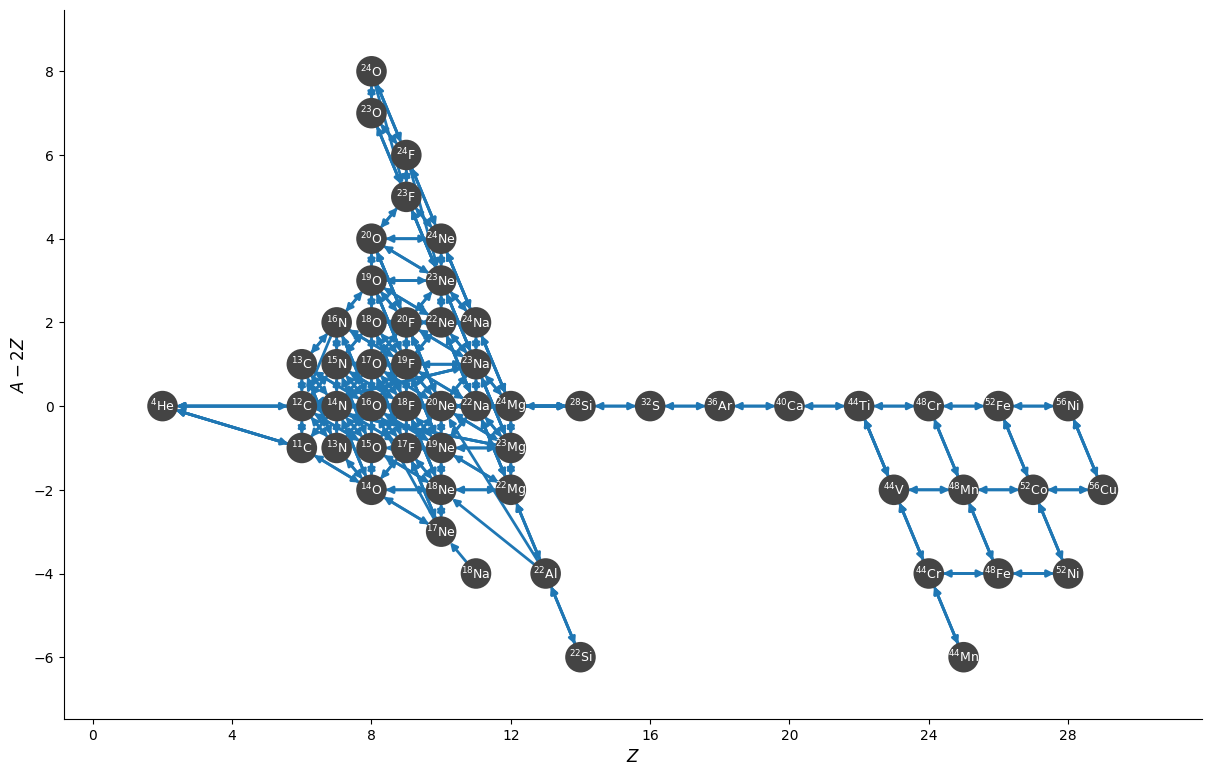

In [15]:
fig = reduced_net.plot(node_size=400, node_font_size="9", size=(1200, 800),
                       rotated=True, hide_xp=True, hide_xalpha=True)